## Main Question
We will predict sales for the thousands of product families sold at Favorita stores located in Ecuador.

### Data Understanding
The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers.  
Additional files include supplementary information that may be useful in building your models. 

The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales:

1. **store_nbr** identifies the store at which the products are sold.
2. **family** identifies the type of product sold.
3. **sales** gives the total sales **for a product family at a particular store at a given date**. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
4. **onpromotion** gives the total number of items in a product family that were being promoted at a store at a given date.

### Exploratory Data Analysis

In [1]:
import pandas as pd

In [2]:
dataset = pd.read_csv("Datasets/Ecuador_sales_record_train.csv")

In [3]:
dataset.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [5]:
# Checking Missing Values
dataset.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [6]:
dataset.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [7]:
# Converting the String format of DATE to datetime object for TimeSeries Analysis.
dataset['date'] = pd.to_datetime(dataset['date'])

In [8]:
# Setting the 'date' column as the index of the DataFrame.
dataset.set_index('date', inplace=True)
# Sorting it to make sure all records are in chronological order.
dataset.sort_index(inplace=True)

In [9]:
dataset.head()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0
2013-01-01,1,1,BABY CARE,0.0,0
2013-01-01,2,1,BEAUTY,0.0,0
2013-01-01,3,1,BEVERAGES,0.0,0
2013-01-01,4,1,BOOKS,0.0,0


**Visualizing Overall Sales Trends**

In [10]:
# Aggregating 'sales' column by date/month (the dataset is large so we choose aggregating by month) to get total sales per month.
# Monthly Sales Plot
dataset_monthly_sales = dataset['sales'].resample('ME').sum()
# The resample() method is specifically designed for time series data and allows you to change the frequency of your data. 
# D (daily), W (weekly), ME (monthly), YE (yearly)

<Axes: title={'center': 'Total Monthly Sales Over Time'}, xlabel='date'>

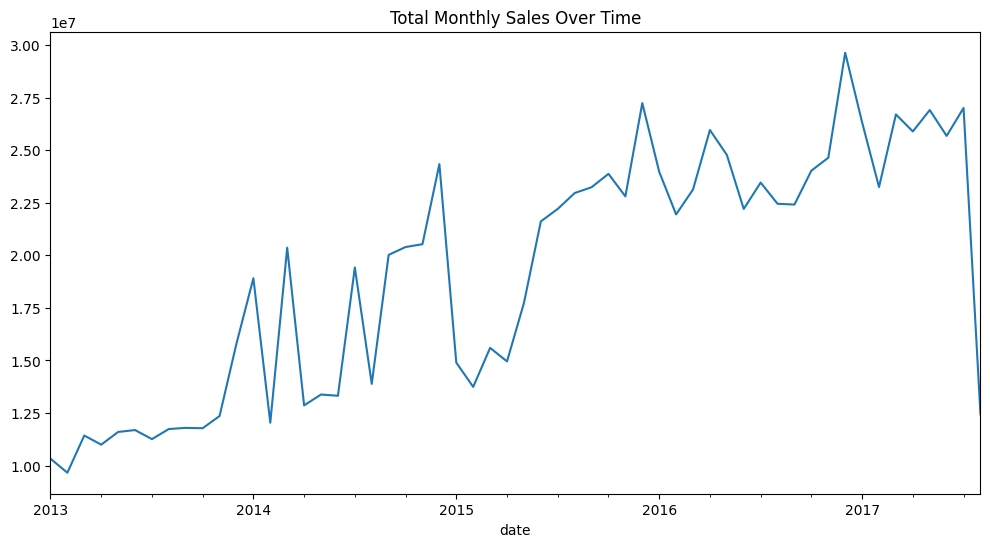

In [11]:
dataset_monthly_sales.plot(title="Total Monthly Sales Over Time", figsize=(12, 6))

**Visualizing Sales Trends by Product Family or Store**

In [12]:
# We can also break down sales by family or store_nbr to explore trends specific to product categories or stores. 
# Here we groupping by 'family' to see if there is specific trends to product categories.
dataset_family_sales = dataset.groupby(['family']).resample('YE').sum()['sales'].unstack(0)

<Axes: title={'center': 'Yearly Sales by Product Family Over Time'}, xlabel='date'>

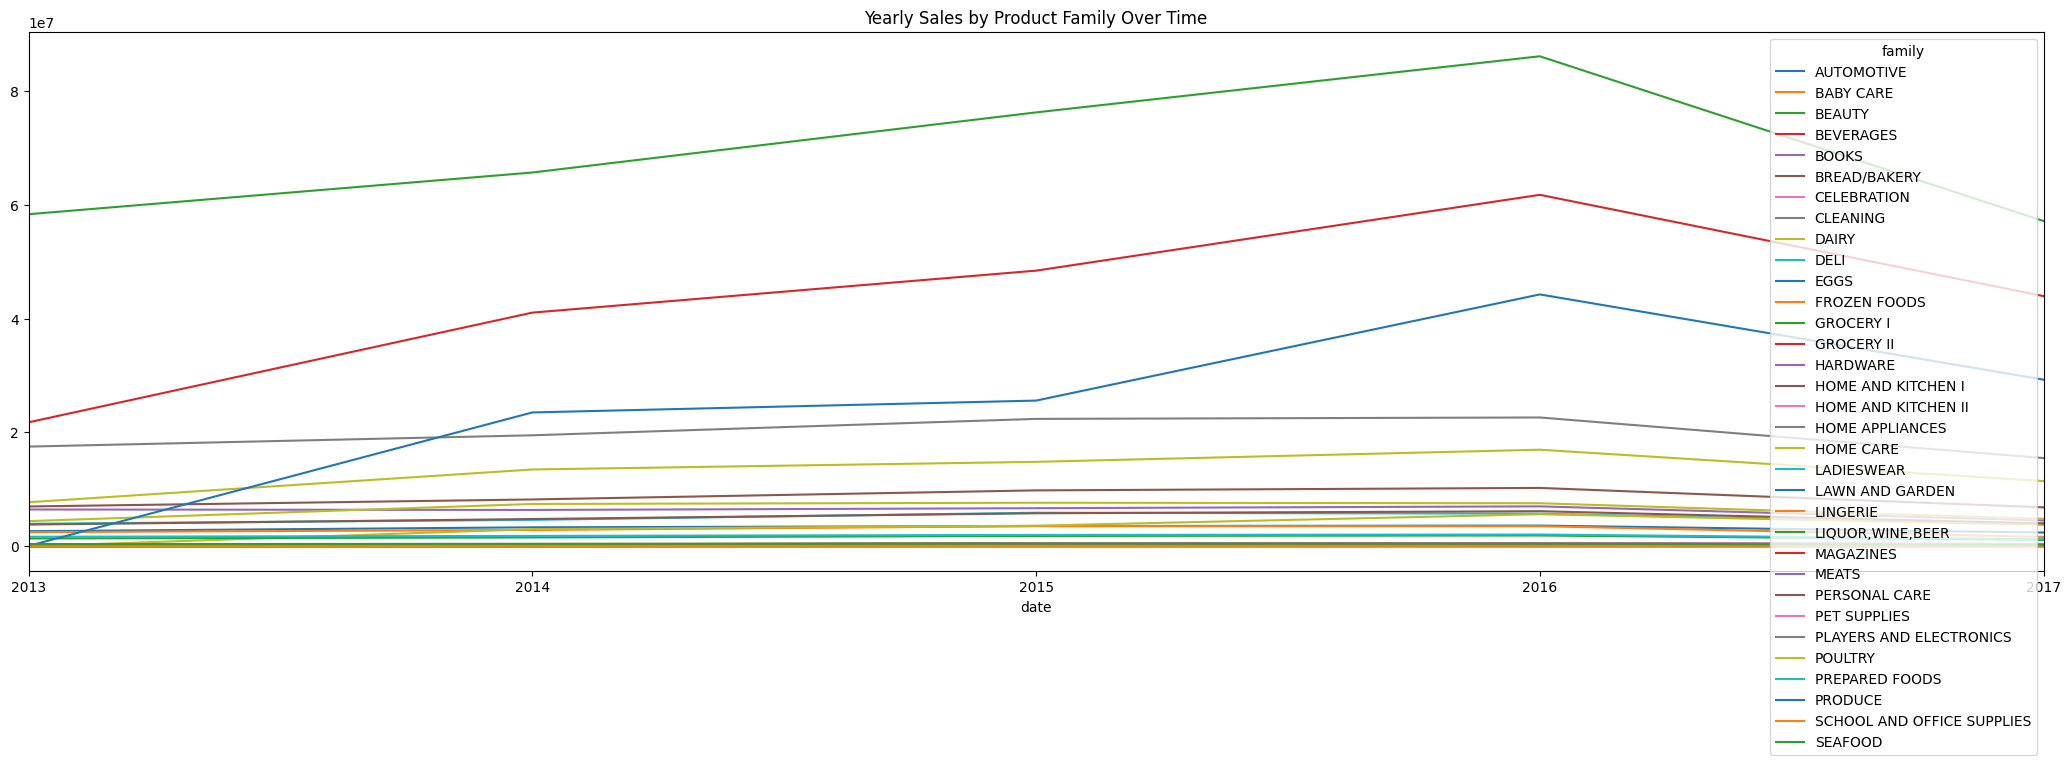

In [13]:
dataset_family_sales.plot(title='Yearly Sales by Product Family Over Time', figsize=(26, 7))

**How sales behave over time for (BEVERAGES) product family**  

We’ll perform a time series decomposition. This technique breaks down the time series into its main components:

1. **Trend**: The overall direction in which the data is moving over time (upward, downward, or stable).  
2. **Seasonality**: Repeating patterns within the data (e.g., weekly or monthly cycles).  
3. **Residual/Noise**: The random, irregular component.  

Time series decomposition is useful because it allows you to analyze each component individually, helping you choose a forecasting model later.  

Time series decomposition breaks down a series into trend, seasonal, and residual components. For the algorithm to accurately identify and separate these components, it needs to see at least two repetitions of the seasonal pattern (e.g., two years of annual seasonality, two months of monthly seasonality).  

With only one cycle, the model cannot confidently separate trend from seasonality, as it might confuse a single cycle’s fluctuations for trend rather than seasonality.  

The period parameter should match the seasonality you’re analyzing:

1. Daily data with weekly seasonality: Use period=7.
2. Daily data with monthly seasonality: Use period=30 or 31.
3. Daily data with yearly seasonality: Use period=365.

In [14]:
# Filtering dataset for a specific product family (BEVERAGES) and aggregate by date.
dataset_beverages = dataset[dataset['family'] == 'BEVERAGES'].resample('W').sum()

In [15]:
dataset_beverages.shape

(242, 5)

In [16]:
# Applying Season Decomposition, by using seasonal_decompose from statsmodels to decompose the sales data for the selected product family.
from statsmodels.tsa.seasonal import seasonal_decompose

In [17]:
# Decompose with an additive model (try multiplicative if the trend is exponential)
decomposition = seasonal_decompose(dataset_beverages['sales'], model='additive', period=7) # Weekly Seasonal

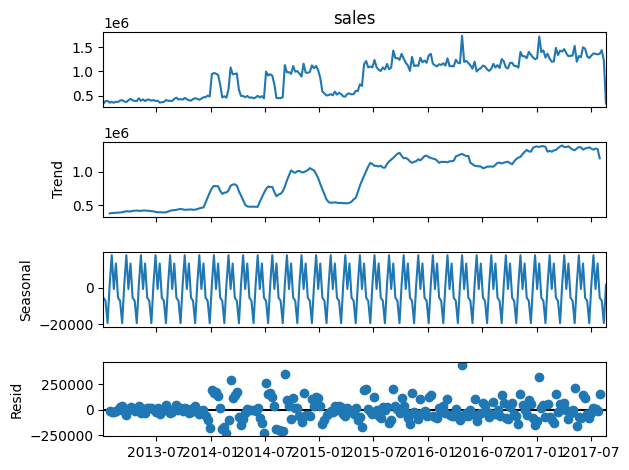

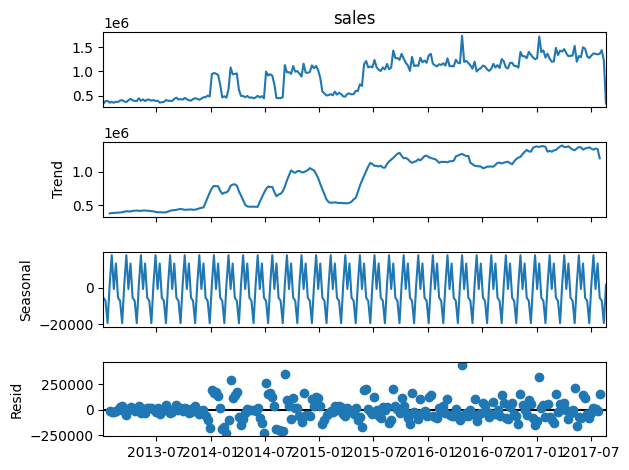

In [18]:
decomposition.plot()

**Observed**  
This is the original time series data, showing the overall pattern of sales over time.  
Use this to identify broad patterns visually, like an upward or downward trend, seasonality, or any anomalies.  

**Trend**  
The Trend component shows the long-term direction of the time series, filtered from seasonal and residual noise.  
If the trend line is increasing, it indicates a general rise in sales over time. A downward trend shows a decrease, and a flat line suggests stability.  
Identical trend lines suggest that the long-term movement is stable across periods and has no drastic shifts.  

**Seasonal**  
The Seasonal component captures repeating patterns or cycles at the chosen frequency (e.g., weekly or monthly).  
Each cycle will show peaks and troughs, reflecting recurring periods of high and low sales. For example:  

1. Weekly seasonality might show higher sales on weekends.
2. Yearly seasonality might reveal holiday or seasonal sales spikes.

Identical seasonal patterns in both plots indicate consistent, predictable fluctuations in sales.

**Residual (or Noise)**  
The Residual component represents what’s left after removing the trend and seasonality. It shows irregularities or random noise.  
Ideally, the residual should appear as random noise without visible patterns. If you see a pattern in the residuals, it may mean that some seasonal or trend patterns were not fully captured.  
Identical residual plots across decompositions might suggest a stable seasonality model without major outliers.  

The seasonal component represents repeating patterns within each week (in this case, with period=7). Since you’ve decomposed with a weekly period, the seasonal component assumes that each week has the same pattern. This is why it will often look identical across each cycle in the plot.

For example, if sales peak on weekends and drop mid-week, this same pattern will repeat in every weekly cycle of the seasonal plot. Identical weekly cycles suggest:

1. **Stable Weekly Patterns**: Your data has consistent weekly patterns—like a weekend sales peak—without major variations.
2. **Reliable Seasonality Model**: The decomposition accurately captures the seasonal structure if the cycles are repeating. It indicates you’re likely working with a predictable weekly pattern.  

The residuals being centered around zero and scattered with a range of -250,000 to 250,000 means:

1. **Low Irregularity**: The model effectively captures the trend and seasonality, as most data points fall close to zero, with only a few larger deviations.
2. **Outliers or Anomalies**: Those points that fall far outside the zero line (closer to ±250,000) represent days with unexpected sales increases or drops. These could be influenced by special events, promotions, or anomalies not captured by weekly seasonality.  

A few spikes in the residuals can be typical, especially in retail sales, where holidays, promotions, or unusual days impact sales. However, if these are minimal, it suggests your data is well-described by the trend and seasonal components.

#### What This Means for The Analysis
Since your seasonal component shows stable weekly cycles, and residuals are largely around zero, this indicates that weekly seasonality is strong and consistent in your data.
This is good news for forecasting because it implies you have a reliable, repeatable pattern and that the model can likely forecast short-term future sales with reasonable accuracy, especially over weeks.

#### Clustering the products 

Analyzing each product family individually can be time-consuming, therefore we choose to **Cluster Product Families by Sales Patterns**.  
Instead of analyzing each product family individually, a common approach is to cluster similar product families based on their sales patterns. For example, we could group products by their average sales volume, trend similarity, or seasonality.

In [19]:
# We need to prepare the data by aggregating sales for each product family over a time period.
# Weekly aggregation
dataset_weekly_productfamilies_aggregated = dataset.groupby(['family']).resample('W').sum()['sales'].reset_index()

In [20]:
dataset_weekly_productfamilies_aggregated.tail()

,family,date,sales
7981,SEAFOOD,2017-07-23,7454.984004
7982,SEAFOOD,2017-07-30,7314.220009
7983,SEAFOOD,2017-08-06,8209.558007
7984,SEAFOOD,2017-08-13,7110.504011
7985,SEAFOOD,2017-08-20,1940.857004


In [21]:
# We need to pivot the aggregated data so that each product family has its own column, and the rows represent time periods.
dataset_pivot = dataset_weekly_productfamilies_aggregated.pivot(index="date", columns='family', values='sales')

In [22]:
dataset_pivot.head()

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2013-01-06,1287.0,0.0,923.0,343176.0,0.0,110834.783110,0.0,327195.0,106415.0,67105.459010,...,0.0,101964.722361,77584.0,0.0,0.0,64861.536995,25504.100981,0.0,0.0,6603.595987
2013-01-13,1514.0,0.0,928.0,395261.0,0.0,123906.703080,0.0,332350.0,118196.0,67466.655030,...,0.0,128575.385107,74299.0,0.0,0.0,70101.329972,31511.893988,0.0,0.0,8173.270000
2013-01-20,1511.0,0.0,925.0,398667.0,0.0,129129.671075,0.0,322213.0,122617.0,69787.654008,...,0.0,128174.407009,68931.0,0.0,0.0,70280.642927,32581.061041,0.0,0.0,8529.757998
2013-01-27,1517.0,0.0,831.0,363118.0,0.0,124825.946970,0.0,311003.0,118195.0,67143.515980,...,0.0,116512.406147,65642.0,0.0,0.0,67781.887988,31771.420978,0.0,0.0,7882.688011
2013-02-03,1807.0,0.0,1043.0,379430.0,0.0,125085.642840,0.0,354687.0,124719.0,73014.606990,...,0.0,124707.358596,77238.0,0.0,0.0,76061.055922,32649.484904,0.0,0.0,8199.115990


In [23]:
# Checking missing values
dataset_pivot.isnull().sum()

family
AUTOMOTIVE                    0
BABY CARE                     0
BEAUTY                        0
BEVERAGES                     0
BOOKS                         0
BREAD/BAKERY                  0
CELEBRATION                   0
CLEANING                      0
DAIRY                         0
DELI                          0
EGGS                          0
FROZEN FOODS                  0
GROCERY I                     0
GROCERY II                    0
HARDWARE                      0
HOME AND KITCHEN I            0
HOME AND KITCHEN II           0
HOME APPLIANCES               0
HOME CARE                     0
LADIESWEAR                    0
LAWN AND GARDEN               0
LINGERIE                      0
LIQUOR,WINE,BEER              0
MAGAZINES                     0
MEATS                         0
PERSONAL CARE                 0
PET SUPPLIES                  0
PLAYERS AND ELECTRONICS       0
POULTRY                       0
PREPARED FOODS                0
PRODUCE                       0
S

**Standardizing the values** the values in the dataset have different ranges!

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [25]:
dataset_scaled = scaler.fit_transform(dataset_pivot)

**Applying Clustering**

In [26]:
# We are using elbow-method for identifying the number of K for KMeans clustering.
from sklearn.cluster import KMeans

interia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(dataset_scaled)
    interia.append(kmeans.inertia_)

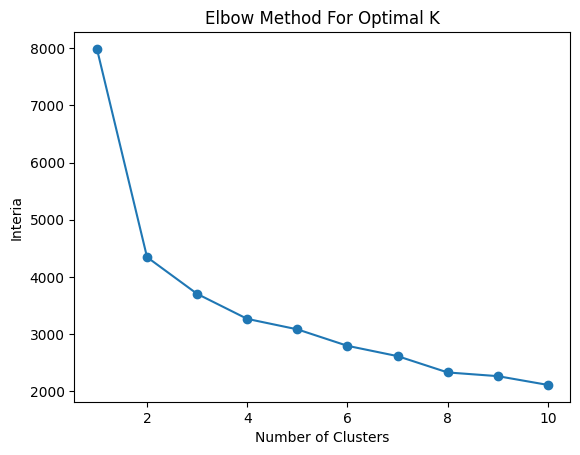

In [27]:
# Visualizing the elbow-method
import matplotlib.pyplot as plt

plt.plot(k_range, interia, marker='o')
plt.title('Elbow Method For Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Interia')
plt.show()

**Fitting the model**

In [28]:
optimal_k = 3 # 2 is also a very good point, but let's try 3 clusters.
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
dataset_pivot['cluster'] = kmeans.fit_predict(dataset_scaled)

In [29]:
# Analyzing the clusters
cluster_means = dataset_pivot.groupby('cluster').mean()
print(cluster_means)

family    AUTOMOTIVE  BABY CARE       BEAUTY     BEVERAGES      BOOKS  \
cluster                                                                 
0        2308.120879  39.065934  1295.538462  9.446647e+05   0.000000   
1        2758.710526  85.078947  2003.250000  1.292807e+06  84.710526   
2        1801.613333   0.400000   903.360000  4.364885e+05   0.000000   

family    BREAD/BAKERY  CELEBRATION       CLEANING          DAIRY  \
cluster                                                             
0        181149.856535  3813.758242  403981.428571  280536.714286   
1        202730.163629  5405.710526  469160.513158  339053.342105   
2        136557.549278    43.880000  334703.733333  175877.520000   

family            DELI  ...    MAGAZINES          MEATS  PERSONAL CARE  \
cluster                 ...                                              
0        102810.076921  ...   952.186813  125514.664933  102446.516484   
1        117496.004484  ...  2349.960526  138549.769850  125403.75

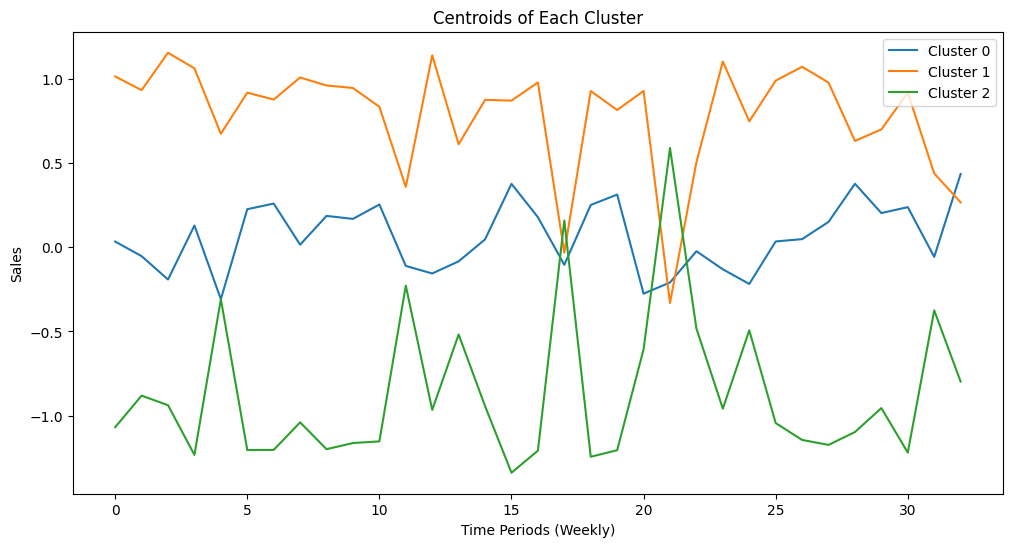

In [30]:
# Plotting the centroids of each cluster
centroids = kmeans.cluster_centers_

plt.figure(figsize=(12, 6))
for i in range(optimal_k):
    plt.plot(centroids[i], label=f'Cluster {i}')
plt.title('Centroids of Each Cluster')
plt.xlabel('Time Periods (Weekly)')
plt.ylabel('Sales')
plt.legend()
plt.show()

Now that we have clusters representing groups of product families with similar sales patterns.

**Analyzing the characteristics of each cluster**  

For each cluster, we can calculate and plot the average sales trends over time to get an idea of how sales behave within each group.  
This will provide insights into seasonal patterns, peaks, and troughs specific to each cluster.

In [ ]:
# Calculating Average Sales Trends per cluster over time:
# 'Sales' are the values in each observation in the dataset_pivot.
cluster_trends = dataset_pivot.groupby(['cluster']).mean()

In [36]:
cluster_trends.head()

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
cluster,,,,,,,,,,,,,,,,,,,,,
0,2308.120879,39.065934,1295.538462,9.446647e+05,0.000000,181149.856535,3813.758242,403981.428571,280536.714286,102810.076921,...,952.186813,125514.664933,102446.516484,1534.538462,2618.000000,143066.252621,37242.436529,604342.359249,954.483516,8865.508474
1,2758.710526,85.078947,2003.250000,1.292807e+06,84.710526,202730.163629,5405.710526,469160.513158,339053.342105,117496.004484,...,2349.960526,138549.769850,125403.750000,2832.644737,4229.276316,150718.236729,39394.232530,882141.027941,2327.236842,8657.661686
2,1801.613333,0.400000,903.360000,4.364885e+05,0.000000,136557.549278,43.880000,334703.733333,175877.520000,77665.455042,...,14.840000,121798.018488,76516.440000,22.133333,39.266667,98698.526558,32224.956273,8890.824817,74.506667,7342.510981


**cluster_trends** now shows the average sales for each product family within each cluster. Each row represents a cluster, and each column represents the average sales of a product family within that cluster.